# Practica Final

In [1]:
%reset
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
plt.style.use('ggplot')

from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import sys
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


<font color = "blue">
    <p>En caso de que No funcione la librería KElbowVisualizer es porque no está instalada. Comando para instalar:</p>
    conda install -c districtdatalabs yellowbrick </p>
    <p>En caso de que No funcione la librería plotly.graph_objects es porque no está instalada. Comando para instalar:pip install plotly==4.14.3

In [2]:
data = pd.read_csv('master.csv')
data_algoritmos = data

In [3]:
data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [4]:
data = data.drop_duplicates()

In [5]:
for col in ['sex', 'age', 'generation']:
    data[col] = pd.Categorical(data[col]).codes.astype(int)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  int32  
 3   age                 27820 non-null  int32  
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  int32  
dtypes: float64(2), int32(3), int64(4), object(3)
memory usage: 2.4+ MB


In [7]:
print("Número de países diferentes:",len(data.country.unique()))
print("Número de generaciones diferentes:",len(data.generation.unique()))
print("Número de años diferentes:",len(data.year.unique()))

Número de países diferentes: 101
Número de generaciones diferentes: 6
Número de años diferentes: 32


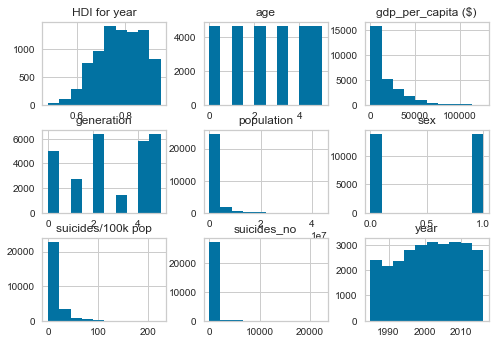

In [8]:
data.hist()
plt.show()

# Análisis del dataset

#### Utilizamos la función describe para tener una primera interpretación general de los datos. Aún no sabemos cuáles serán los datos más significativos del dataset, a parte de los obvios, número de suicidios y número de suicidios por cada 100k habitantes.
#### La hipótesis que propusimos para este proyecto consistía en la refutación de la afirmación de que aquellos países con un PIB alto también tenían una tasa de suicidios alta. Esta hipótesis es un poco vaga, y hemos decidido ampliar la búsqueda, queremos encontrar cuales son las causas de que en un país haya más suicidios que en otros, o al menos descartar cuales no son causas comunes.
#### Creemos que los países son una frontera perfecta, cada país tiene unas características propias de diferentes formas de vida de una población, debido a los diferentes índices de desarrollo personal, el PIB, el número de habitantes... estos atributos definen de en parte la forma de vida en un país. En este datase encontramos 101 países, los cuales la mayoría son europeos y americanos.
#### Vamos a hacer una breve descripción de los datos:

-  	Población: en primer lugar, encontramos que la población varía mucho entre unos países y otros, vemos que el país con menos habitantes es kiribati con menos de 4000 habitantes, por otro lado, EEUU con más de 260 millones de habitantes.
-   Country: país
-	Year: periodo de años, abarca de 1985 a 2015
-	country-year: esta columna se compone de el nombre del país y el año, pero
-	Sexo: hombre o mujer
-	gdp_for_year: es el PIB de un país de un año.
-	GDP_per_capita: PIB dividido por la población estimada para mediados del mismo año.
-	HDI for year: es el Índice de desarrollo humano por año.
-	Generation: encontramos las siguientes generaciones:
	  - G.I. Generation
	  - Silent
	  - Boomers
	  - Generación X
	  - Millenials
      - Generación Z
-	Age: dividimos las edades en cuatro grupos:
	  - 5-14
	  - 15-24
	  - 25-34
	  - 35-54
	  - 55-74
      - 75+
-	suicides_no: número de suicidios.
-	suicides/100k pop: número de suicidios por cada 100.000 habitantes.

- suicides/100k pop: número de suicidios por cada 100.000 habitantes.

In [9]:
data.describe()

,year,sex,age,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($),generation
count,27820.000000,27820.000000,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000,27820.000000
mean,2001.258375,0.500000,2.499425,242.574407,1.844794e+06,12.816097,0.776601,16866.464414,2.701869
std,8.469055,0.500009,1.708754,902.047917,3.911779e+06,18.961511,0.093367,18887.576472,1.809836
min,1985.000000,0.000000,0.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000,0.000000
25%,1995.000000,0.000000,1.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000,1.000000
50%,2002.000000,0.500000,2.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000,2.000000
75%,2008.000000,1.000000,4.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000,4.000000
max,2016.000000,1.000000,5.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000,5.000000


#### Hemos considerado que sería una buena práctica hacer un análisis de los datos antes de emplear alguno de los algoritmos que hemos aprendido en la asignatura.

In [10]:
data['suicides/100k pop'].max()

224.97

##### En primer lugar, vamos a averiguar cuáles son los países con mayor media de índice de suicidios cada 100k de personas. Queremos ver si existe algún patrón en lo países dependiendo de este índice. Podrían darse más suicidios dependiendo del clima, o del tipo de sociedad o gobierno, que son datos que no forman parte del dataset.

In [11]:
dfMediaSuicidosPorPaises = data.groupby('country')['suicides/100k pop'].mean()

## Estudio Países con mayor índice de suicidio
##### Aquí podemos ver un gráfico de barras con los 20 países con mayor media de suicidios por cada 100k. Observamos que esta lista es sorprendentemente parecida a los datos que ofrece la OMS, estos datos utilizan fuentes también parecidas a nuestro dataset, los años abarcan de 1985 a 2018.
##### Vemos que muchos de estos países formaron parte de la URSS o al menos debieron adoptar políticas impuestas por la Unión Soviética, lamentablemente al comenzar nuestro dataset en 1985 no podemos asegurar que tenga que ver, ya que no sabemos si los años predecesores tienen índices menores o mayores, o si empeoró debido al gran colapso económico en 1980.
##### Otro grupo que podemos reconocer son los países asiáticos como República de Corea, Japón, o Sri Lanka. Estos países, al igual que los primeros, coinciden en que todos tienen un modelo social muy rígido y jerarquizado, donde hay no cabida a las decisiones individuales. Son modelos de vida patriarcales donde se impone al individuo las decisiones del padre de familia.
##### Por otro lado, también encontramos otro grupo de países que no sabemos muy bien el porqué de ese índice tan alto de suicidios, entre los que se encuentran Francia y Bélgica.

<AxesSubplot:xlabel='country'>

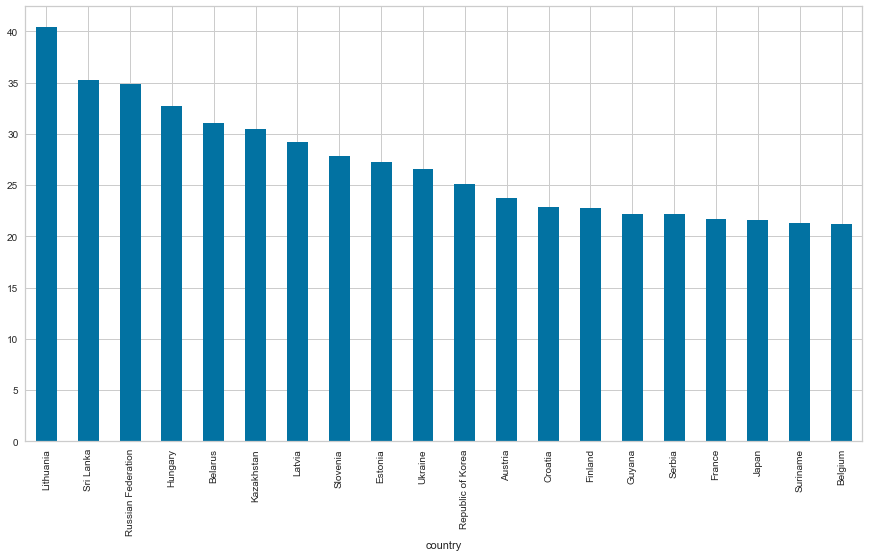

In [12]:
dfMediaSuicidosPorPaises.nlargest(20).plot.bar(figsize=(15,8))

##### Vamos a estudiar más a fondo estos países, empezando por Lituania. Observamos que los datos comienzan en 1995 y como veremos más adelante, en otra parte de nuestro estudio, el índice de suicidio desciende conforme van pasando los años. 

<AxesSubplot:xlabel='year'>

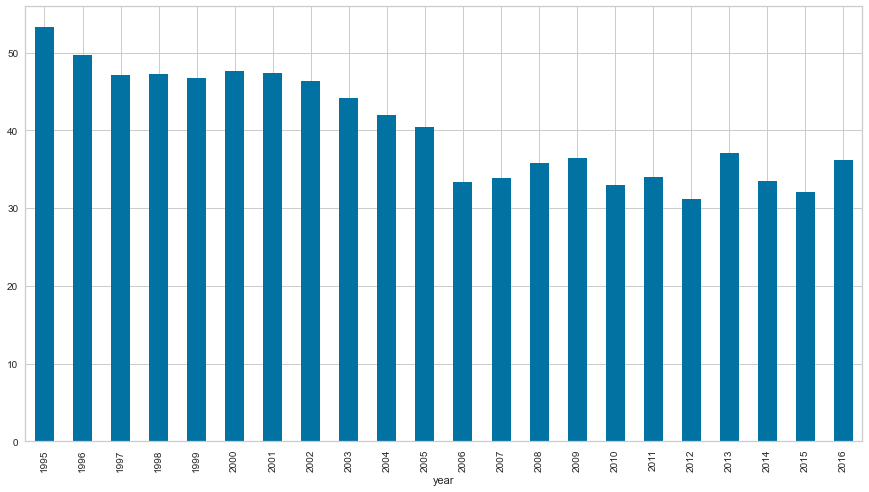

In [13]:
Lithuania_Study = data.loc[data['country'] == 'Lithuania'];
Lithuania_Study = Lithuania_Study.groupby('year')['suicides/100k pop'].mean()

Lithuania_Study.plot.bar(figsize=(15,8))

#### De Rusia tenemos datos desde algo anteriores a los de Lituania, desde 1989, dos años antes de la dilución de la Unión Soviética. A partir de 1991 hay un fuerte crecimiento en el número de suicidios, debido a la crisis política y económica. Después, esta tasa va descendiendo según se van estabilizando la política y la economía como veremos en el siguiente gráfico.

<AxesSubplot:xlabel='year'>

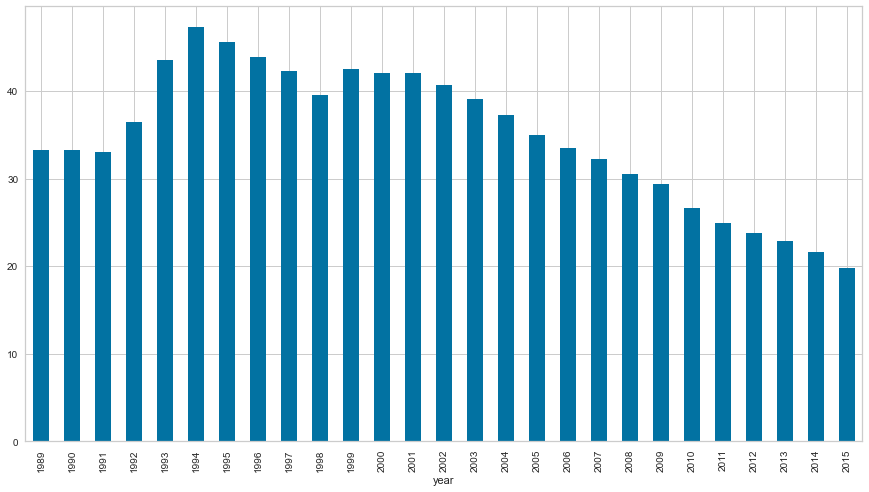

In [14]:
Russian_Federation = data.loc[data['country'] == 'Russian Federation'];
Russian_Federation = Russian_Federation.groupby('year')['suicides/100k pop'].mean()

Russian_Federation.plot.bar(figsize=(15,8))

##### El PIB per cápita asciende a un ritmo alto a partir de 2001, coincidiendo con la bajada del índice de suicidio, aunque esta no desciende a un ritmo tan alto. Puede existir una relación, pero hemos llegado a la conclusión de que el PIB per cápita o el PIB, no es un reflejo demasiado fiel a la hora de ver la forma de vida de un país, ya que, aunque un país genere mucha riqueza el PIB per cápita solo es una división de la riqueza entre la población. Por lo tanto, como ya sabemos, la mayor parte de la riqueza es poseída por unos pocos, mientras que las condiciones de la mayoría varían levemente.
##### En conclusión, en el análisis de Rusia, el PIB puede ser importante, pero no tan decisivo como en un primer momento sospechábamos. No hemos podido estudiar el HDI porque no hay datos de Rusia.

<AxesSubplot:xlabel='year'>

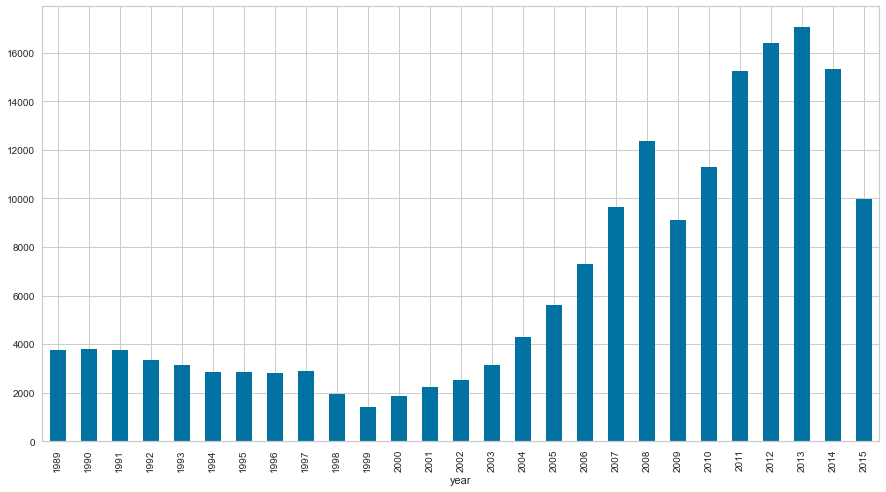

In [15]:
Russian_Federation = data.loc[data['country'] == 'Russian Federation']
Russian_Federation = Russian_Federation.rename(columns={' gdp_for_year ($) ': 'gdp_for_year', 'gdp_per_capita ($)': 'gdp_per_capita'})
Russian_Federation = Russian_Federation.groupby('year')['gdp_per_capita'].mean()
Russian_Federation.plot.bar(figsize=(15,8))

## Estudio de países con menor índice de suicidio
#### Ahora, continuamos con el análisis de los países con menor tasa de suicidios. Vemos que existe un grupo de países caribeños como Jamaica, Antigua y Barbuda, San Cristóbal y Nieves... estos países suelen tener un PIB bajo y una densidad de población moderada acercándonos a alta y un HDI bajo.
#### Hay otro grupo de países árabes muy ricos que también se encuentran en esta clasificación. Entre ellos Emiratos Árabes o Catar, con un PIB no demasiado alto, pero con un PIB per cápita altísimo.

<AxesSubplot:xlabel='country'>

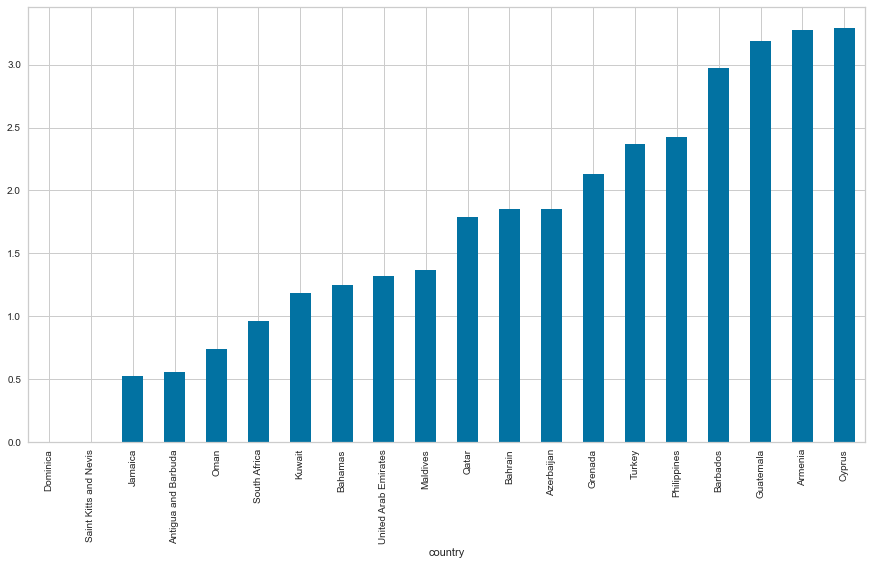

In [16]:
dfMediaSuicidosPorPaises.nsmallest(20).plot.bar(figsize=(15,8))

#### El PIB en Jamaica a aumentado, al igual que el de la mayoría de estos países, su situación económica se ha mantenido más o menos estable, así como el número de suicidios.

<AxesSubplot:xlabel='year'>

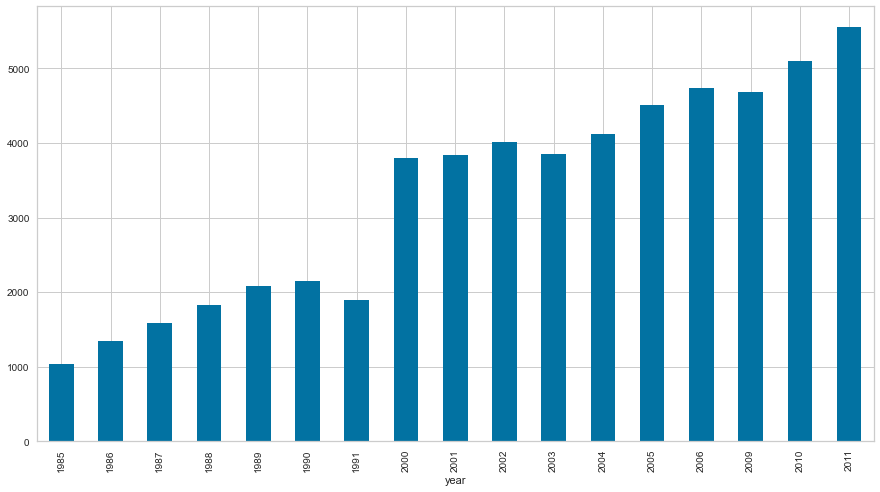

In [17]:
Jamaica = data.loc[data['country'] == 'Jamaica']
Jamaica = Jamaica.rename(columns={' gdp_for_year ($) ': 'gdp_for_year', 'gdp_per_capita ($)': 'gdp_per_capita'})
Jamaica = Jamaica.groupby('year')['gdp_per_capita'].mean()
Jamaica.plot.bar(figsize=(15,8))

#### El análisis por género lo abordaremos más detalladamente más adelante.

In [18]:
data.groupby('sex').max()

,country,year,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
sex,,,,,,,,,,,
0,Uzbekistan,2016,5,4053,43805214,133.42,Uzbekistan2014,0.944,"997,007,926",126352,5
1,Uzbekistan,2016,5,22338,43139910,224.97,Uzbekistan2014,0.944,"997,007,926",126352,5


### Análisis de grupos de edad
#### Debemos aclarar que una cosa son las franjas de edad y otra son las generaciones, cada generación tiene o tendrá todos los grupos de edad. 
#### Aquí el resultado varía mucho dependiendo del punto de vista. Si nos preguntamos cual es la franja de edad con mayor número de suicidios, es la de 35 a 54, pero porque la población que pertenece a ese grupo es mucho mayor que la población que tiene más de 75 años.
#### Porcentualmente, el grupo que más suicidios tiene en relación con el número de personas que lo forman es el de mayores de 75. 
#### Lo que nos hace preguntarnos, ¿las personas que lo cometen presentan estas tendencias toda su vida? o se debe a las circunstancias.

<AxesSubplot:xlabel='age'>

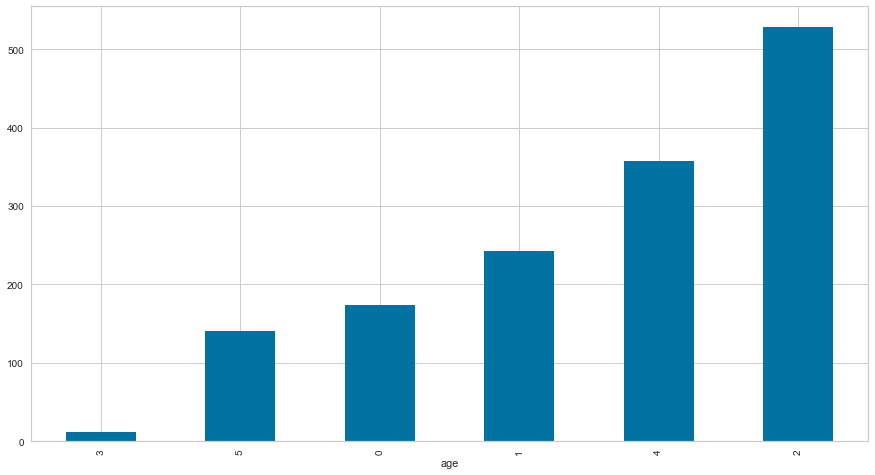

In [19]:
data_age = data.groupby('age')['suicides_no'].mean()
data_age.nsmallest(6).plot.bar(figsize=(15,8))

<AxesSubplot:xlabel='age'>

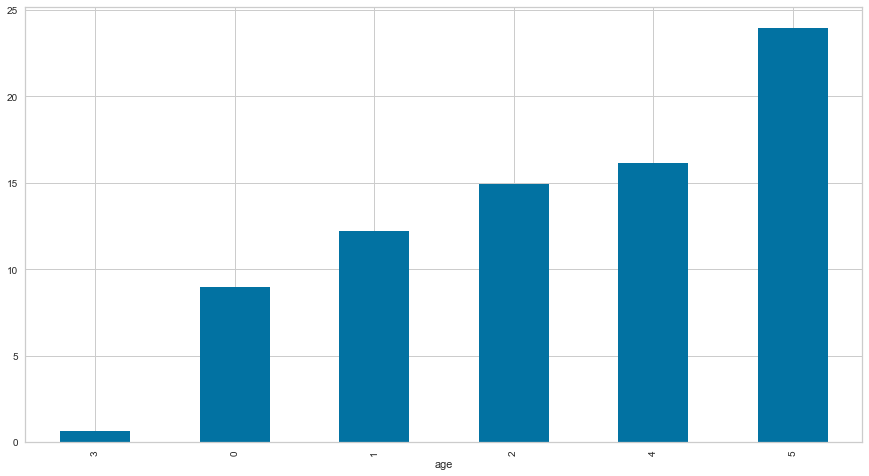

In [20]:
data_age = data.groupby('age')['suicides/100k pop'].mean()
data_age.nsmallest(6).plot.bar(figsize=(15,8))

### Análisis de grupos de edad a lo largo de los años
#### Encontramos que estos grupos en ningún momento se cortan entre ellos, mantienen tendencias muy parecidas, cuando uno crece el otro también lo hace y viceversa. Lo que nos indica que aproximadamente a todos afecta por igual las circunstancias. También podemos ver que existe una tendencia a disminuir hacia abajo.

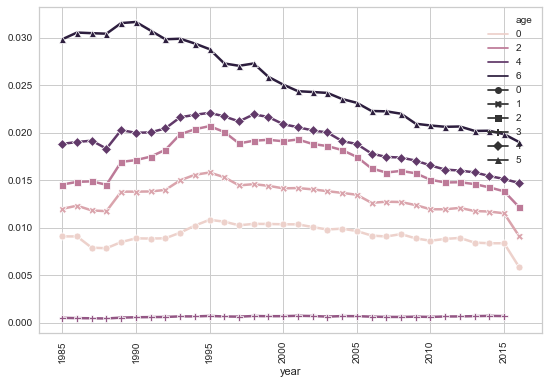

In [21]:
Edad = data.groupby(["year","age"])["suicides_no", "population"].sum()
Auxiliar = Edad.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot("year", Auxiliar.suicides_no*100/Auxiliar.population, hue = "age",data = Auxiliar, linewidth = 2.5, style = "age", markers=True, dashes=False)
plt.xticks(rotation = 90)
plt.show()

### Análisis de Generaciones
#### En este análisis confirmamos que existe una tendencia a la baja de suicidios según van pasando los años. Pero es un análisis parcial, ya que aunque tenemos todos los datos de la generación G.I. y casi todos los de Silent, quedan tres generaciones que aún son muy jóvenes como para poder asegurar nada, especialmente los millenials y la generación Z.

<AxesSubplot:xlabel='generation'>

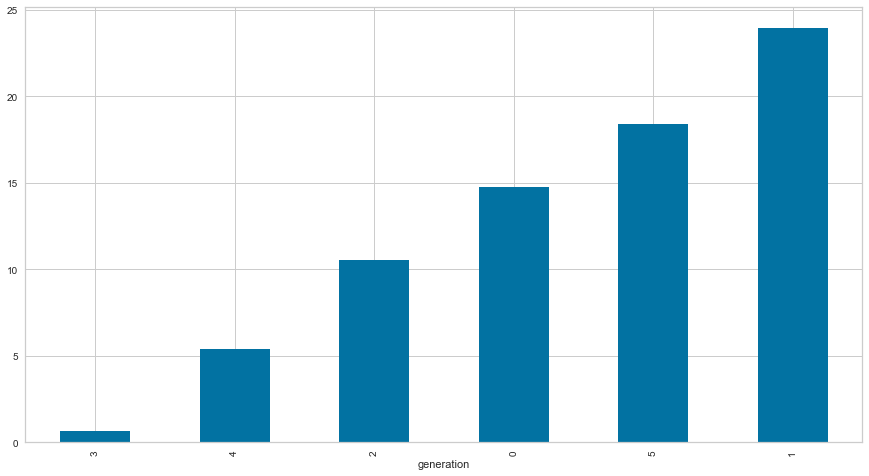

In [22]:
data_generation = data.groupby('generation')['suicides/100k pop'].mean()
data_generation.nsmallest(6).plot.bar(figsize=(15,8))

#### Volvemos a ver lo mismo, según van pasando los años en cada generación el número de suicidios aumenta, porque como hemos visto, el número de individuos aumenta desde los 15 hasta los 54 y después vuelve a descender.

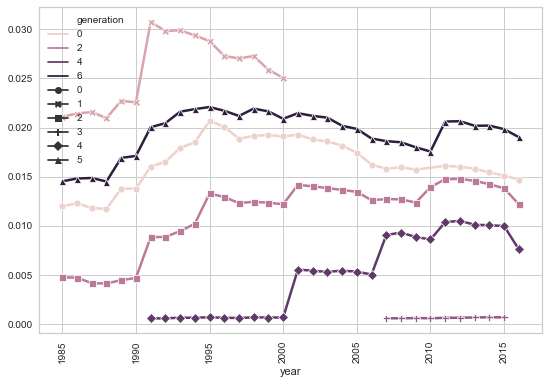

In [23]:
Generacion = data.groupby(["year","generation"])["suicides_no", "population"].sum()
Auxiliar = Generacion.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot("year", Auxiliar.suicides_no*100/Auxiliar.population, hue = "generation",data = Auxiliar, linewidth = 2.5, style = "generation", markers=True, dashes=False)
plt.xticks(rotation = 90)
plt.show()

### Experimento 1: ¿Coinciden las épocas de crisis con una mayor tasa de suicidios?
#### Para eso buscamos los años donde se han cometido más suicidios. pensábamos que en épocas de crisis políticas o económicas serían las más propensas a que se cometiesen este tipo de actos. 
#### En la siguiente gráfica hemos ordenado los países y los años con mayor número de individuos muertos por cada 100.000 habitantes.
#### Vemos que Hungría en la década de los 90 aparece repetida varias veces, creemos que puede tener que ver el cambio de paradigma político, de nuevo observamos una transición de un modelo comunista tipo soviético a un modelo de democracia occidental, a pesar de haber sido una transición relativamente discreta, la implantación de un nuevo sistema económico y político es algo muy complicado, lo que pudo ser una de las causas del aumento de la tasa.

<AxesSubplot:xlabel='country-year'>

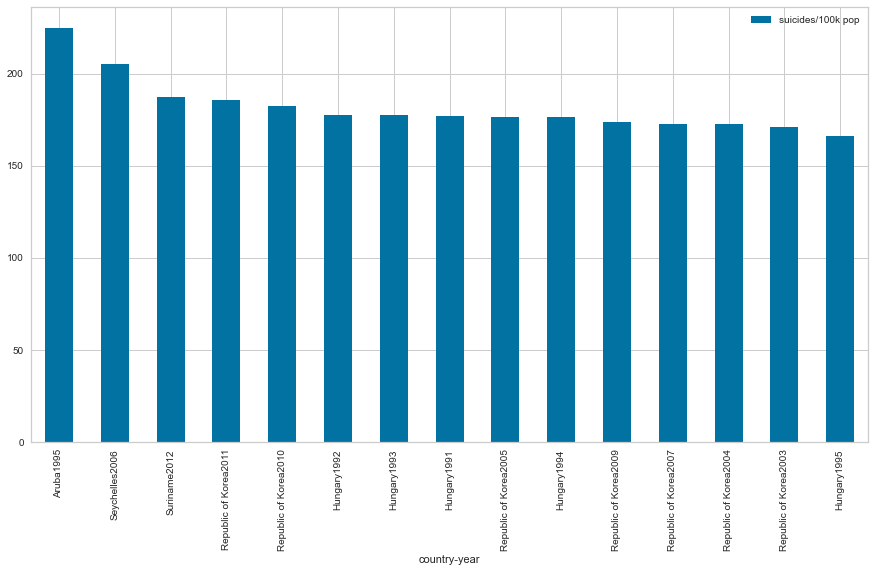

In [24]:
df_age = data.groupby(["country", "year"])["suicides/100k pop", "country-year"].max()


aux = pd.DataFrame(df_age)
aux.nlargest(15, "suicides/100k pop").plot.bar(figsize=(15,8),x="country-year", y='suicides/100k pop')

### Experimento 2: estudios de PIB per cápita y número de suicidios

#### Tratamos de ver si existe una relación directa entre el PIB per cápita y la tasa de suicidios, lo estudiaremos de dos formas diferentes, buscaremos si existe algún patrón en las gráficas y por supuesto también realizaremos una matriz de correlación. 
#### En el primer paso, creamos una gráfica de barras cuya ‘x’ está formada por los valores del PIB per cápita de menor a mayor y cuya ‘y’ por los valores de número de suicidios por cada 100.000 habitantes de dicho país. Pronto nos damos cuenta de que no hay ningún patrón, como ya habíamos adelantado antes.

<AxesSubplot:xlabel='gdp_per_capita ($)'>

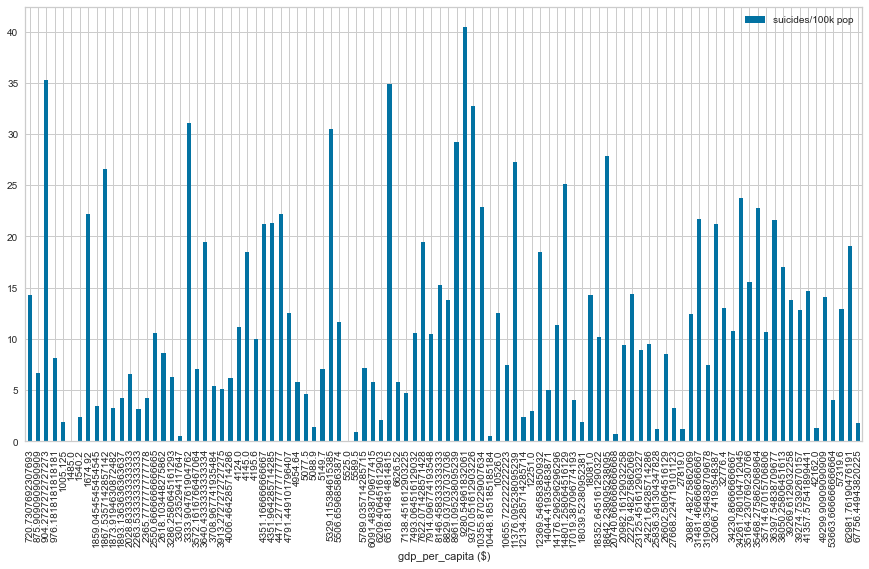

In [25]:
data_gdp_capita = data.groupby('country')['gdp_per_capita ($)', 'suicides/100k pop'].mean()
data_gdp_capita.nsmallest(100, 'gdp_per_capita ($)').plot.bar(x='gdp_per_capita ($)', y='suicides/100k pop',figsize=(15,8))

#### En este segundo paso hemos medido la correlación entre estos dos valores y confirmamos que no tiene mucho que ver.

In [26]:
data_gdp_capita.corr()

,gdp_per_capita ($),suicides/100k pop
gdp_per_capita ($),1.000000,0.038206
suicides/100k pop,0.038206,1.000000


#### Hemos pensado que una matriz de correlación nos ayudaría a continuar nuestro análisis con los algoritmos.
#### La matriz nos muestra que no hay correlación en los datos de este dataset, lo que nos hace sospechar que el suicidio es algo que no se puede medir solo con los datos que tenemos. Hemos leído artículos acerca de esto, y el libro "El suicidio" de Durkheim, a pesar de tener más de 120 años y debemos tomar sus datos con relativo cuidado, apunta a que el suicidio tiene mucho que ver con causas extra sociales, herencia, estados psicopáticos... y en cuanto a cuestiones sociales, tienen mucho que ver causas que no podemos medir adecuadamente, como la religión, la política, o la educación, algunos de los países con mejor formación académica son también aquellos que más individuos se suicidan.
#### Por último, como apunte, la población masificada parece afectar más al índice de natalidad a la tasa de suicidio.

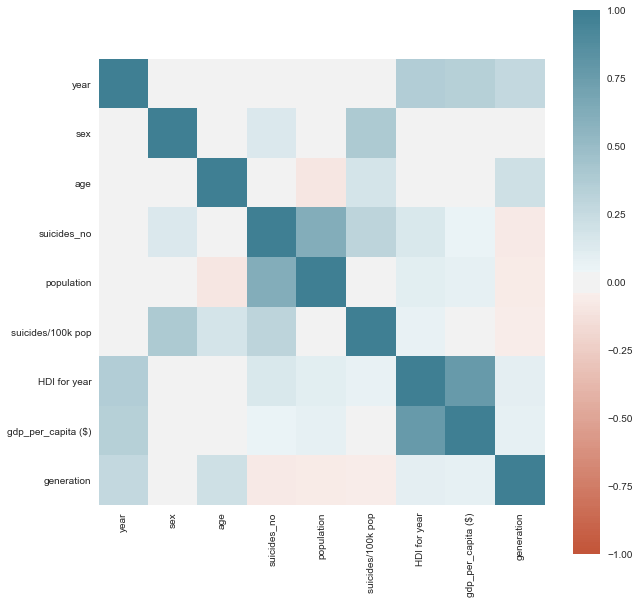

In [27]:
corr=data.corr()
f,ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Estudio de algortimos

### Algoritmo a priori

<font color = "blue">
    <p>El motivo de la aplicación del algoritmo a priori consiste en encontrar un conjunto de itemset frecuentes con el fin de generar una reglas de asociación que nos ayuden a encontrar patrones según los datos que tenemos.</p>
    <p>Para poder aplicar el algoritmo apriori hemos tenido que generar un dataset que hace referencia un itemset a cada uno de los individuos que se han suicidado.</p>
    <p>De esta forma generamos un itemset mucho mayor con un total de 154300 valores, o lo que es lo mismo, 130000 datos más que con el dataset inicial. Para realizarlo, hemos necesitado la población del país y la tasa de suicidios, obeniendo una regla de tres en la que conseguimos aumentar los datos, tal y como se ha ocmentado anteriormente.</p>
    <p>A si mismo, no se utilizarán todos los valores proporcionados del dataset, solo los más interesantes para el estudio: país en el que ocurre, año en el que ocurre, sexo del individuo y generacion a la que pertenece.</p>


In [28]:
#para realizar este mdelo debemos modificar el dataset para obtener solo
#Para el algoritmo a priori utilizaremos los datos de: country, year, sex y generation
columnas = ['country','year','sex','generation','population','suicides/100k pop']
dataset_a_priori = data[columnas]
dataset_a_priori

,country,year,sex,generation,population,suicides/100k pop
0,Albania,1987,1,2,312900,6.71
1,Albania,1987,1,5,308000,5.19
2,Albania,1987,0,2,289700,4.83
3,Albania,1987,1,1,21800,4.59
4,Albania,1987,1,0,274300,3.28
...,...,...,...,...,...,...
27815,Uzbekistan,2014,0,2,3620833,2.96
27816,Uzbekistan,2014,0,5,348465,2.58
27817,Uzbekistan,2014,1,3,2762158,2.17
27818,Uzbekistan,2014,0,3,2631600,1.67


In [29]:
daf = pd.DataFrame(columns = columnas)
for i in range(dataset_a_priori.shape[0]):
    pob = int(dataset_a_priori.population[i])
    suicide_rel = int(dataset_a_priori['suicides/100k pop'][i])
    cant = int(pob*suicide_rel/4000000)
    z = pd.DataFrame(dataset_a_priori.iloc[i,:]).T
    if cant >= 1: 
        daf = pd.concat([daf,pd.concat([z]*cant)])

daf = daf.drop(['population'], axis=1)
daf = daf.drop(['suicides/100k pop'], axis=1)

In [30]:
daf

,country,year,sex,generation
588,Argentina,1985,1,1
588,Argentina,1985,1,1
588,Argentina,1985,1,1
588,Argentina,1985,1,1
589,Argentina,1985,1,1
...,...,...,...,...
27814,Uzbekistan,2014,0,4
27814,Uzbekistan,2014,0,4
27814,Uzbekistan,2014,0,4
27815,Uzbekistan,2014,0,2


<font color="blue">
    <p>El siguiente dataframe será el itemset con el que buscaremos las reglas de asociación, con 112 columnas relativas a los distintos países, años, generaciones y sexo.</p>

In [31]:
daf['year'] = daf['year'].astype('str')
daf['generation'] = daf['generation'].astype('str')
daf = pd.get_dummies(daf)
#dataset_a_priori.columns.values
daf.head(5)

,country_Argentina,country_Australia,country_Austria,country_Azerbaijan,country_Belarus,country_Belgium,country_Bosnia and Herzegovina,country_Brazil,country_Bulgaria,country_Canada,...,year_2015,year_2016,sex_0,sex_1,generation_0,generation_1,generation_2,generation_3,generation_4,generation_5
588,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
588,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
588,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
588,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
589,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [32]:
#creamos todas las funciones necesarias
def calculo_itemset (dataset,min_soporte):
    frequent_itemsets = apriori(dataset, min_support=min_soporte, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return  frequent_itemsets
def itemset_frecuentes(itemsets, k):
    new_itemsets = itemsets[(itemsets['length'] == k) & (itemsets['support'] >= min_soporte)]
    return new_itemsets
def itemset_frecuentes_mayor_1(itemsets):
    itemsets = itemsets[(itemsets['length'] >= 2) & (itemsets['support'] >= min_soporte)]
    return itemsets
def itemsets_frecuentes(itemsets):
    itemsets = itemsets[(itemsets['support'] >= min_soporte)]
    return itemsets
def reglas_asociacion(itemsets):
    reglas = association_rules(itemsets, metric="confidence", min_threshold=0)
    return reglas
def reglas_alta_confianza (reglas, confianza):
    filtro = reglas.confidence >= confianza
    alta_confianza = reglas[filtro]
    return alta_confianza
def reglas_antecesor(reglas, antecesor):
    new_reglas = reglas[reglas['antecedents'] == {antecesor}]
    return new_reglas
def reglas_confianza(reglas, umbral):
    filtro = reglas.confidence >= confianza
    new_reglas = reglas[filtro]
    return new_reglas

<font color="blue">
    <p>A partir de Aquí, ya aplicaremos el algoritmo a priori como tal, buscando los itemsetfrecuentes y sus respectivas reglas de confianza.</p>

In [33]:
soporte = 0.05
min_soporte = 0.1
# Ahora aplicaremos todas las funciones a un ejemplo concreto.
#primero creamos todos los itemsets
itemset = calculo_itemset(daf,soporte)
#guardamos los itemset relativos a k = 1
itemset_k_1 = itemset_frecuentes(itemset,1)
# los relativos a k= 2
itemset_k_2 = itemset_frecuentes(itemset,2)
# y k = 3
itemset_k_3 = itemset_frecuentes(itemset,3)

In [34]:
# ahora obtenemos todas las reglas
reglas = reglas_asociacion(itemset)
reglas

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(sex_1),(country_Japan),0.790540,0.126862,0.087943,0.111244,0.876893,-0.012346,0.982428
1,(country_Japan),(sex_1),0.126862,0.790540,0.087943,0.693219,0.876893,-0.012346,0.682768
2,(sex_1),(country_Russian Federation),0.790540,0.191957,0.159270,0.201470,1.049557,0.007520,1.011913
3,(country_Russian Federation),(sex_1),0.191957,0.790540,0.159270,0.829717,1.049557,0.007520,1.230070
4,(country_Russian Federation),(generation_0),0.191957,0.347664,0.075207,0.391793,1.126928,0.008471,1.072555
5,(generation_0),(country_Russian Federation),0.347664,0.191957,0.075207,0.216322,1.126928,0.008471,1.031090
6,(sex_1),(country_United States),0.790540,0.160125,0.129304,0.163564,1.021475,0.002718,1.004111
7,(country_United States),(sex_1),0.160125,0.790540,0.129304,0.807516,1.021475,0.002718,1.088198
8,(generation_0),(country_United States),0.347664,0.160125,0.055483,0.159586,0.996635,-0.000187,0.999359
9,(country_United States),(generation_0),0.160125,0.347664,0.055483,0.346495,0.996635,-0.000187,0.998210


In [35]:
# filtramos aquellas reglas que son de alta confianza:
reglas_confianza_5 = reglas_alta_confianza(reglas,0.5)
reglas_confianza_5

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(country_Japan),(sex_1),0.126862,0.79054,0.087943,0.693219,0.876893,-0.012346,0.682768
3,(country_Russian Federation),(sex_1),0.191957,0.79054,0.159270,0.829717,1.049557,0.007520,1.230070
7,(country_United States),(sex_1),0.160125,0.79054,0.129304,0.807516,1.021475,0.002718,1.088198
15,(generation_0),(sex_1),0.347664,0.79054,0.283644,0.815856,1.032024,0.008802,1.137481
17,(generation_1),(sex_1),0.075395,0.79054,0.050268,0.666724,0.843378,-0.009335,0.628489
19,(generation_2),(sex_1),0.224068,0.79054,0.185071,0.825961,1.044807,0.007937,1.203526
20,(generation_4),(sex_1),0.084944,0.79054,0.070168,0.826050,1.044920,0.003016,1.204144
23,(generation_5),(sex_1),0.267527,0.79054,0.201020,0.751398,0.950488,-0.010471,0.842554
26,"(country_Russian Federation, generation_0)",(sex_1),0.075207,0.79054,0.065517,0.871146,1.101963,0.006062,1.625557


In [36]:
# preparamos para hacer las gráficas para visualizar las reglas obtenidas
cantidad_reglas_confianza_por_antecesor = reglas_confianza_5.groupby(['antecedents']).size().reset_index(name='counts')
cantidad_reglas_confianza_por_antecesor["antecedents"] = cantidad_reglas_confianza_por_antecesor["antecedents"].apply(lambda x: list(x)).astype("unicode")
cantidad_reglas_por_antecesor = reglas.groupby(['antecedents']).size().reset_index(name='counts')
cantidad_reglas_por_antecesor["antecedents"] = cantidad_reglas_por_antecesor["antecedents"].apply(lambda x: list(x)).astype("unicode")

<BarContainer object of 9 artists>

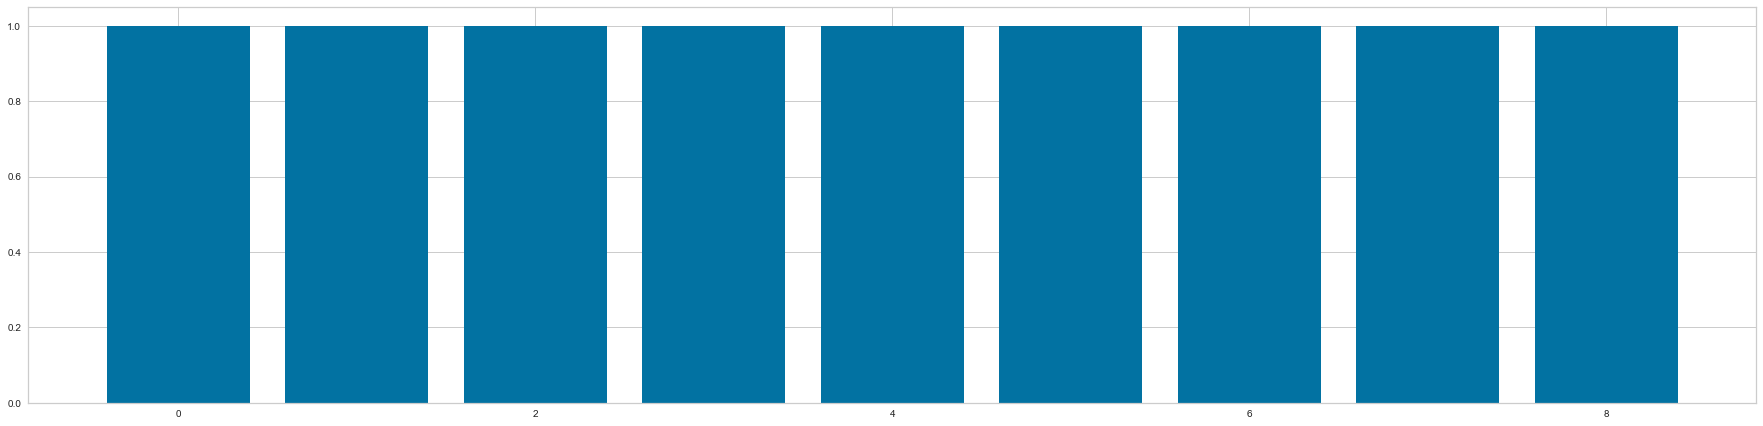

In [37]:
# ahora crearemos un diagrama de barras para saber las reglas con alta confianza que comparten antecesor.
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
antecedentes_fig = np.arange(len(cantidad_reglas_confianza_por_antecesor["antecedents"]))
cantidades_fig = cantidad_reglas_confianza_por_antecesor["counts"]

ax.bar(antecedentes_fig,cantidades_fig)

<font color = "blue">
    <p>Tal y como podemos ver en esta gráfica, en las reglas de alta confianza los antecedentes tienen en su totalidad un antecedente distinto, por lo que significa que estas reglas son muy pequeñas y selectivas.</p>
</font>

<BarContainer object of 13 artists>

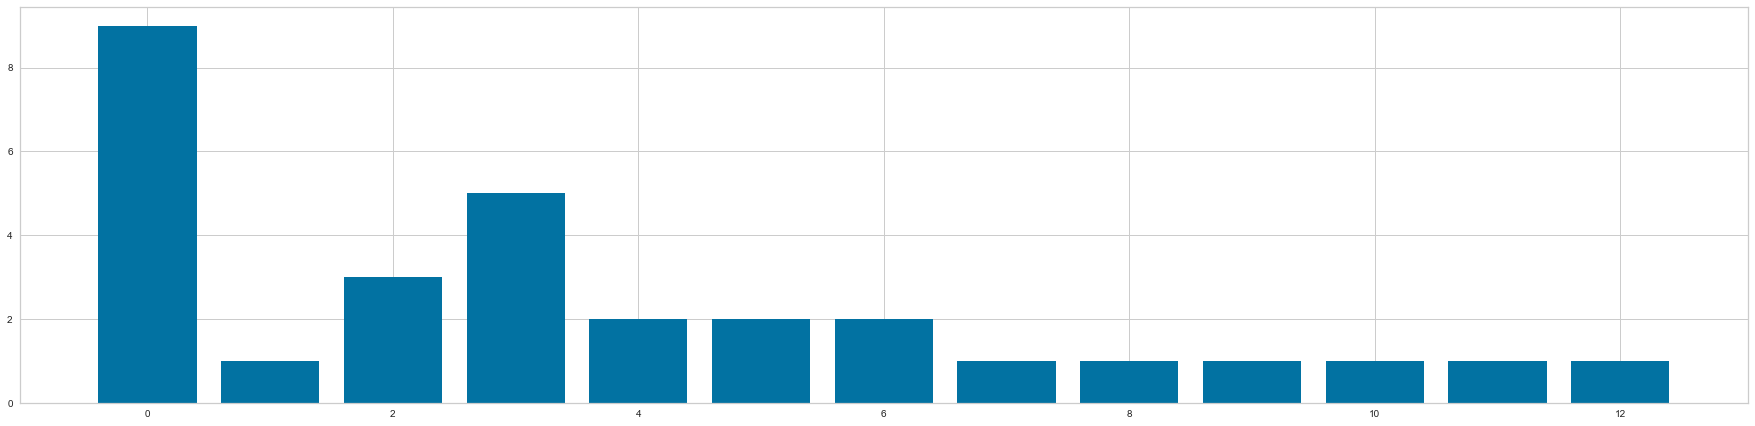

In [38]:
# ahora crearemos un diagrama de barras para saber las reglas sin alta confianza que comparten antecesor.
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
consecuentes_fig = np.arange(len(cantidad_reglas_por_antecesor["antecedents"]))
cantidades_fig = cantidad_reglas_por_antecesor["counts"]

ax.bar(consecuentes_fig,cantidades_fig)

<font color = "blue">
    <p>En esta gráfica, podemos observar que existen 13 antecedentes diferentes en los cuales en dos superan la cantidad de 5 unidades. Esto significa que hay muchas reglas que comparten antecedentes.</p>
</font>

In [39]:
cantidad_reglas_confianza_por_consequents = reglas_confianza_5.groupby(['consequents']).size().reset_index(name='counts')
cantidad_reglas_confianza_por_consequents["consequents"] = cantidad_reglas_confianza_por_consequents["consequents"].apply(lambda x: list(x)).astype("unicode")
cantidad_reglas_por_consequents = reglas.groupby(['consequents']).size().reset_index(name='counts')
cantidad_reglas_por_consequents["consequents"] = cantidad_reglas_por_consequents["consequents"].apply(lambda x: list(x)).astype("unicode")

<BarContainer object of 1 artists>

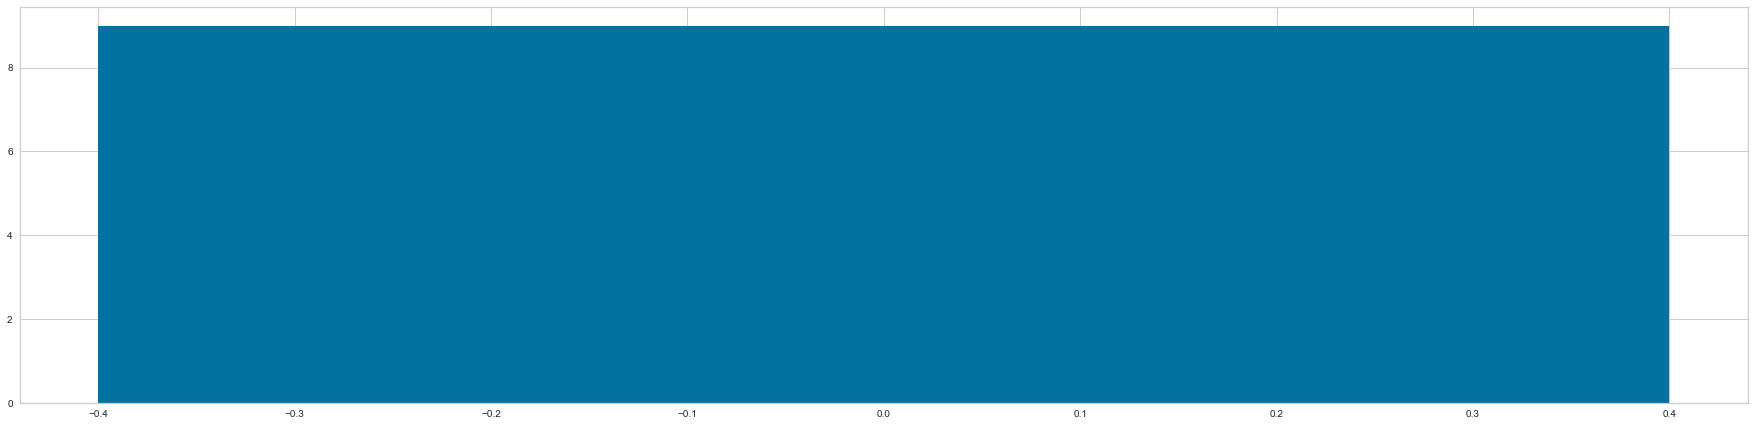

In [40]:
# ahora crearemos un diagrama de barras para saber las reglas con alta confianza que comparten consecuentes.
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
consecuentes_fig = np.arange(len(cantidad_reglas_confianza_por_consequents["consequents"]))
cantidades_fig = cantidad_reglas_confianza_por_consequents["counts"]

ax.bar(consecuentes_fig,cantidades_fig)

<font color = "blue">
    <p>Esta gráfica representa los distintos consecuentes que nos encontramos en todas las reglas generadas. Tal y como se puede observar en esta gráfica, solo nos encontramos con un antecesor(sex).</p>
    <p>Esto puede surgir debido a que la mayoría de reglas que hemos obtenido además de las de altac onfianza, cuentan muchas veces con este dato tan utilizado.</p>
</font>

<BarContainer object of 13 artists>

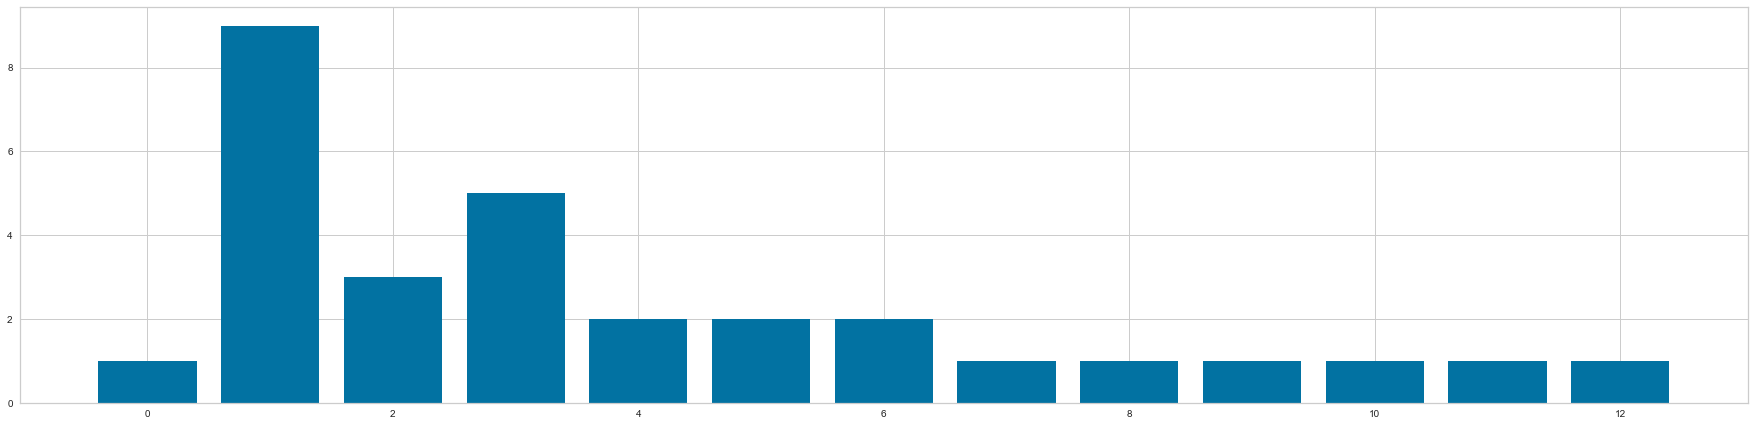

In [41]:
# ahora crearemos un diagrama de barras para saber las reglas sin alta confianza que comparten consecuentes.
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
consecuentes_fig = np.arange(len(cantidad_reglas_por_consequents["consequents"]))
cantidades_fig = cantidad_reglas_por_consequents["counts"]

ax.bar(consecuentes_fig,cantidades_fig)

<font color="blue">
    <p>Esta gráfica nos presenta los consecuentes distintos que hay en todas las reglas. Y, funciona de la misma forma que su respectiva gráfica de antecedentes</p>
</font>

 ### KNN

In [42]:
columnas_KNN = ['HDI for year','suicides/100k pop','generation']

dataset_KNN = data[columnas_KNN]
dataset_KNN.head(5)

aux = pd.DataFrame(columns = columnas_KNN)
for i in range(dataset_KNN.shape[0]):
    pob = int(data.population[i])
    suicide_rel = int(data['suicides/100k pop'][i])
    cant = int(pob*suicide_rel/4000000)
    z = pd.DataFrame(dataset_KNN.iloc[i,:]).T
    if cant >= 1: 
        aux = pd.concat([aux,pd.concat([z]*cant)])
aux

,HDI for year,suicides/100k pop,generation
588,0.694,55.65,1.0
588,0.694,55.65,1.0
588,0.694,55.65,1.0
588,0.694,55.65,1.0
589,0.694,24.29,1.0
...,...,...,...
27814,0.675,5.92,4.0
27814,0.675,5.92,4.0
27814,0.675,5.92,4.0
27815,0.675,2.96,2.0


In [43]:
dataf = aux
dataf
dataframe = dataf
dataframe

,HDI for year,suicides/100k pop,generation
588,0.694,55.65,1.0
588,0.694,55.65,1.0
588,0.694,55.65,1.0
588,0.694,55.65,1.0
589,0.694,24.29,1.0
...,...,...,...
27814,0.675,5.92,4.0
27814,0.675,5.92,4.0
27814,0.675,5.92,4.0
27815,0.675,2.96,2.0


<font color = "blue">
    <p>
        Una vez estudiados los datos, creemos que se puede obtener una relación entre el índice de desarrollo humano (HDI for year) y el número de suicidos de cada país, que nos permita establecer la generación a la que pertenezca el individuo que se haya seleccionado. Para ello, se ha implementado el algoritmo KNN, y se ha estudiado el mejor valor de K, para ofrecer resultados óptimos en función de los datos.  
    </p>

In [44]:
#Primero se preprocesan los datos para que pueda trabajar el algoritmo KNN, ya que daba una serie de problemas al 
#operar con datos de tipo float
lab_enc = preprocessing.LabelEncoder()
dataframe['suicides/100k pop'] = lab_enc.fit_transform(dataframe['suicides/100k pop'])
dataframe['HDI for year'] = lab_enc.fit_transform(dataframe['HDI for year'])

In [45]:
#Se localizan los datos: para el eje x, el indice de desarrollo humano y el PIB anual; y para el eje y las generaciones
X = dataframe[['HDI for year','suicides/100k pop']].values
y = dataframe['generation'].values

#Se dividen los datos en subconjuntos de entrenamiento y test que serán utilizados más adelante. Se usa un random state de 42,
#para elegir de manera aleatoria cada individuo de cada subgrupo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

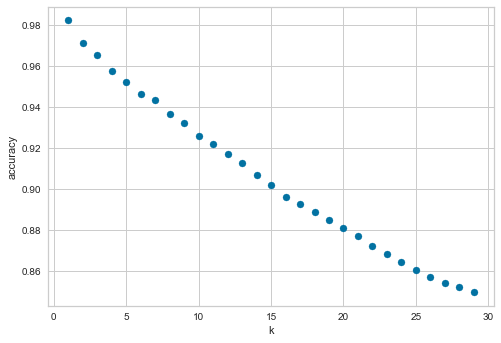

In [46]:
#Se realiza un estudio del mejor valor de k, para los datos presentados. 
k_range = range(1, 30)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)

<font color = "blue">
    <p>
        Como podemos obervar, la precisión en función del valor de K presenta un decrecimiento lineal, debido a que debe clasificar en cinco clases diferenciadas (cada generación). Esto es debido a que se presentan datos muy repetidos (hay países, que cuentan con cinco registros iguales del indice humano de desarrollo -HDI- por ejemplo), y va disminuyendo la precisión debido a esas repeticiones, por lo que se elige tomar un valor pequeño. Se escoge k = 2, aunque k = 1 ofrezca mejores resultados, ya que si elegimos k = 1,se realiza un ajuste excesivo de los datos a la hora de clasificarlos, aun presentando el valor más óptimo en cuanto a la clasificación se refiere.
    </p>

In [47]:
#Se prueba el modelo con la k elegida
n_neighbors = 2

knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.97


In [48]:
#Se imprime la matriz de confusión y el reporte de clasificaciones, con el fin de validar los resultados del algoritmo
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print("\n\n")
print(classification_report(y_test, pred))

[[13324     9    49     0    24    34]
 [   54  2827    27     0     1    25]
 [  186    42  8375     0    26    33]
 [    3     0     5    11     0     1]
 [   79    20    98     0  3068    19]
 [  152    59   101     1    51  9890]]



              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13440
         1.0       0.96      0.96      0.96      2934
         2.0       0.97      0.97      0.97      8662
         3.0       0.92      0.55      0.69        20
         4.0       0.97      0.93      0.95      3284
         5.0       0.99      0.96      0.98     10254

    accuracy                           0.97     38594
   macro avg       0.96      0.90      0.92     38594
weighted avg       0.97      0.97      0.97     38594



# K - Means

In [49]:
data = data.rename(columns={' gdp_for_year ($) ': 'gdp_for_year', 'gdp_per_capita ($)': 'gdp_per_capita'})

### Con la aplicación de este algoritmo queremos observar si ha habido algun cambio en la tendencia del numero de suicidios a traves del tiempo. Para esto vamos aplicar kmeans al año 1987 y al 2014 y estudiaremos las diferencias

<font color="blue">
Eliminamos las columnas que no os interesan para el análisis.

In [50]:
data_kmeans = data.drop(['sex', 'age', 'suicides/100k pop', 'HDI for year', 'gdp_for_year', 'gdp_per_capita','generation','country-year'], axis=1)

In [51]:
data_kmeans

,country,year,suicides_no,population
0,Albania,1987,21,312900
1,Albania,1987,16,308000
2,Albania,1987,14,289700
3,Albania,1987,1,21800
4,Albania,1987,9,274300
...,...,...,...,...
27815,Uzbekistan,2014,107,3620833
27816,Uzbekistan,2014,9,348465
27817,Uzbekistan,2014,60,2762158
27818,Uzbekistan,2014,44,2631600


In [52]:
data_kmeans_1987 =  data_kmeans[data_kmeans['year'] == 1987]
data_kmeans_2014 =  data_kmeans[data_kmeans['year'] == 2014]
data_kmeans_1987

,country,year,suicides_no,population
0,Albania,1987,21,312900
1,Albania,1987,16,308000
2,Albania,1987,14,289700
3,Albania,1987,1,21800
4,Albania,1987,9,274300
...,...,...,...,...
27251,Uruguay,1987,19,352300
27252,Uruguay,1987,7,206100
27253,Uruguay,1987,7,243700
27254,Uruguay,1987,1,267000


<font color="blue">
    Tal y como esta el dataset tenemos que transfornmarlo para adaptarlo a nuestras necesidades. Por lo que agrpumaos por pais y relizamos la suma para obtener el numero de total de suicidios y de la poblacion analizado.

In [53]:
data_kmeans_1987 = data_kmeans_1987.groupby( ['country'], sort= False).sum()
data_kmeans_2014 = data_kmeans_2014.groupby( ['country'], sort= False).sum()
data_kmeans_1987 = data_kmeans_1987.drop(['year'],axis =1) 
data_kmeans_2014 = data_kmeans_2014.drop(['year'],axis =1) 

<font color="blue">
<p>Quitamos la columna year</p>
<p>Y pasamos a un array para trabajar mejor</p>

In [54]:
data_kmeans_1987 = data_kmeans_1987.values
data_kmeans_2014 = data_kmeans_2014.values

<font color="blue">
    Comenzamos la búsqueda de la mejor 'K' para el algoritmo. Para ello estudiamos cual es el comportamiento del algoritmo para diferntes K's.

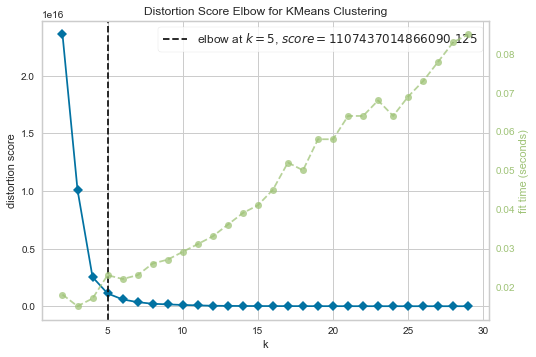

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(data_kmeans_1987)     
visualizer.show()  

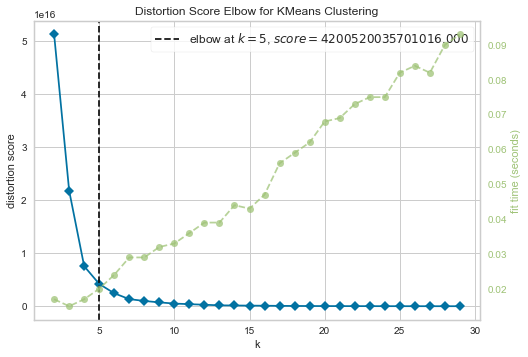

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(data_kmeans_2014)     
visualizer.show() 

### Como podemos ver el mejor k es 5 por lo que lo utilizaremos para estudiar los resultados

<font color = "blue">A continuacion crearenos los modelos y evauaremos su utilidad para nuestra hipotesis.

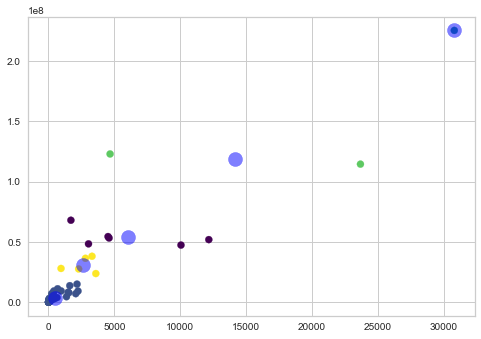

In [57]:
kmeans = KMeans(n_clusters=5, algorithm='full', n_init=40).fit(data_kmeans_1987)# creamos el modelo de kmeans para k=5
centroids = kmeans.cluster_centers_#añadimos los centroides
kmeans.n_iter_
labels = kmeans.predict(data_kmeans_1987)
plt.scatter(data_kmeans_1987[:, 0], data_kmeans_1987[:, 1], c=labels, s=50, cmap='viridis')#pintamos el dataset
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=200, alpha=0.5);#pintamos los centroides

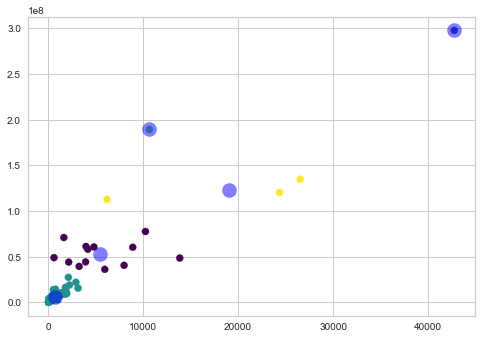

In [58]:
kmeans = KMeans(n_clusters=5, algorithm='full', n_init=40).fit(data_kmeans_2014)# creamos el modelo de kmeans para k=5
centroids = kmeans.cluster_centers_#añadimos los centroides
kmeans.n_iter_
labels = kmeans.predict(data_kmeans_2014)
plt.scatter(data_kmeans_2014[:, 0], data_kmeans_2014[:, 1], c=labels, s=50, cmap='viridis')#pintamos el dataset
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='blue', s=200, alpha=0.5);#pintamos los centroides

# Conclusion Kmeans

<font color="blue">Tal y como podemos observar en las graficas anteriores no hay casi ninguna variacion del numero de suidcidios por poblacion. Si que ha un cambio en la escala como es normal, hay mas poblacion pero el numerod e suicidios en lospasises evaluadps no ha aumentado significativamente. Esta experimento no nos ha parecido en un primer momento muy relevante pero viendo los resultados obtenidps en otras secciones nos da a entender que que al contrario de lo que pensabamos en un principioel porcentaje de suicidios por pais no ha crecido como creiamos.